In [4]:
import pandas as pd
import seaborn as sns
import pickle as pkl
from pathlib import Path
import re
import sys
import json

sys.path.append(str(Path().resolve().cwd().parent / "EbayData"))
from EbayData import scraper

In [ ]:
with open('config/thinkpad_t_search_config.json', 'rt') as F:
    options = json.load(F)['options']
with open('config/cookie.txt', 'rt') as F:
    cookie = F.read()

In [7]:
query_dict = {
    'Thinkpad T14 Gen 3': {'regex': 'T14S? Gen ?3', 'year': 2022},
    'Thinkpad T14 Gen 2': {'regex': 'T14S? Gen ?2', 'year': 2021},
    'Thinkpad T14 Gen 1': {'regex': 'T14S? Gen ?1', 'year': 2020},
    'Thinkpad T490': {'regex': 'T490', 'year': 2019},
    'Thinkpad T495': {'regex': 'T495', 'year': 2019},
    'Thinkpad T480':{'regex': 'T480', 'year': 2018},
    'Thinkpad A485':{'regex': 'A485', 'year': 2018},
    'Thinkpad T470':{'regex': 'T470', 'year': 2017},
    'Thinkpad A475':{'regex': 'A475', 'year': 2017},
    'Thinkpad T460':{'regex': 'T460', 'year': 2016},
    'Thinkpad T450':{'regex': 'T450', 'year': 2015}
}
data_dict ={}
for model, info in query_dict.items():
    print(model)
    options["Release%20Year"] = info["year"]
    data_dict[model] = scraper(model, options=options, cookie=cookie, verbose=False)

Thinkpad T14 Gen 3
Thinkpad T14 Gen 2
Thinkpad T14 Gen 1
Thinkpad T490
Thinkpad T495
Thinkpad T480
Thinkpad A485
Thinkpad T470
Thinkpad A475
Thinkpad T460
Thinkpad T450


In [8]:
with open('thinkpad_15_22.pkl', 'wb') as f:
    pkl.dump(data_dict, f)

In [10]:
for model, df in data_dict.items():
    df['model_year'] = query_dict[model]['year']
    df['model'] = model
tp_data = pd.concat([df for df in data_dict.values()])
tp_data = tp_data.reset_index(drop=True)

In [11]:
condition_dict = {
    'Brand New': 'condition_new',
    'Open Box': 'condition_like_new',
    'Certified - Refurbished': 'condition_refurbished_0',
    'Excellent - Refurbished': 'condition_refurbished_1',
    'Very Good - Refurbished': 'condition_refurbished_2',
    'Good - Refurbished': 'condition_refurbished_3',
    'Refurbished': 'condition_refurbished_4',
    'Pre-Owned': 'condition_used'
}
tp_data['condition'] = None
for condition_tag, col_name in condition_dict.items():
    condition_subset = tp_data['tags'].apply(lambda tags: condition_tag in tags)
    tp_data.loc[condition_subset, 'condition'] = col_name

In [12]:
# Filtering
tp_data_filt = tp_data.loc[~tp_data['seller_name'].isnull()]

In [23]:
# Fix model years


def model_fix(row):
    prod_name = str(row['name']).lower()
    for model, model_info in model_dict.items():
        res = re.search(model_info['regex'], prod_name, flags=re.IGNORECASE)
        if res is not None:
            return model_info['year'], model
    return None, None
        
tp_data_filt[['fixed_model_year', 'fixed_model']] = tp_data_filt.apply(model_fix, axis=1, result_type='expand')

C:\Users\peace\AppData\Local\Temp\ipykernel_13228\798519133.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_data_filt[['fixed_model_year', 'fixed_model']] = tp_data_filt.apply(model_fix, axis=1, result_type='expand')


In [26]:
# Model Fix cont.
tp_data_filt = tp_data_filt.loc[~tp_data_filt['fixed_model'].isnull()]
tp_data_filt['model_year'] = tp_data_filt['fixed_model_year']
tp_data_filt['model'] = tp_data_filt['fixed_model']

In [58]:
def cost_per_year(row):
    year = row['model_year']
    price = row['price']
    remaining_years = year - 2015 + 1
    mean_price_per_year = price/remaining_years
    return mean_price_per_year

tp_data_filt['cost_per_year'] = tp_data_filt.apply(cost_per_year, axis=1)

<AxesSubplot:xlabel='price', ylabel='Density'>

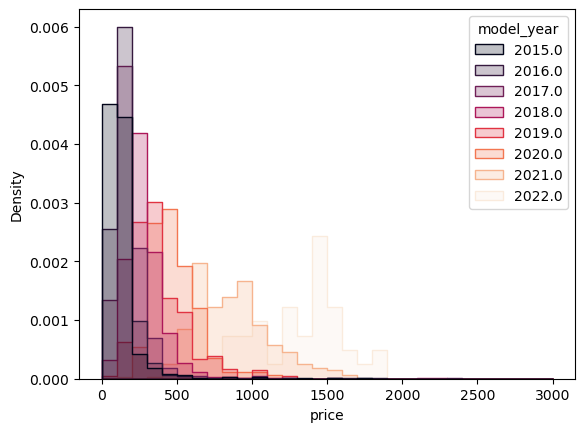

In [27]:
sns.histplot(
    tp_data_filt, 
    x='price', 
    stat='density',
    common_norm=False,
    binrange=[0,3000], 
    binwidth=100,
    element='step',
    hue='model_year', 
    palette=sns.color_palette("rocket", as_cmap=True))

<AxesSubplot:xlabel='model_year', ylabel='price'>

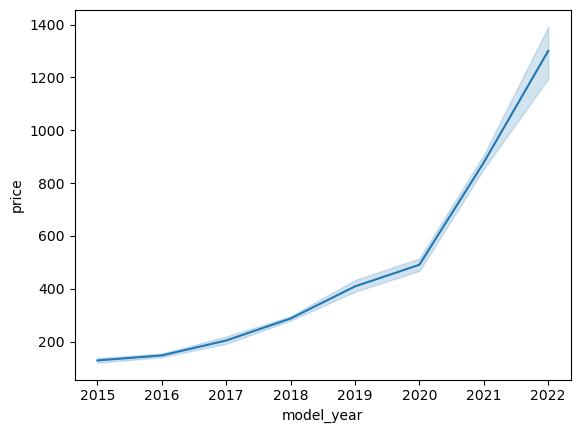

In [71]:
sns.lineplot(data=tp_data_filt, x='model_year', y='price')

<AxesSubplot:xlabel='model_year', ylabel='cost_per_year'>

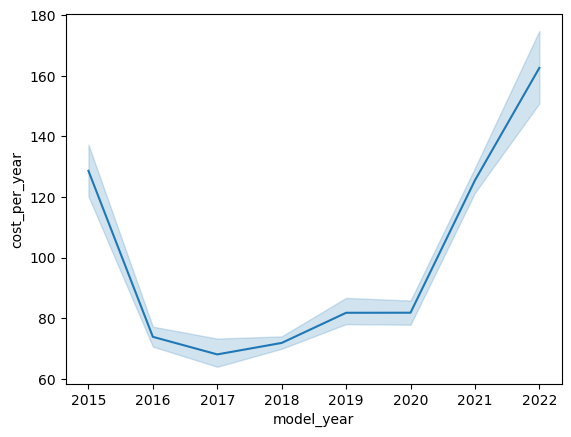

In [70]:
sns.lineplot(data=tp_data_filt, x='model_year', y='cost_per_year')

<AxesSubplot:xlabel='model_year', ylabel='price'>

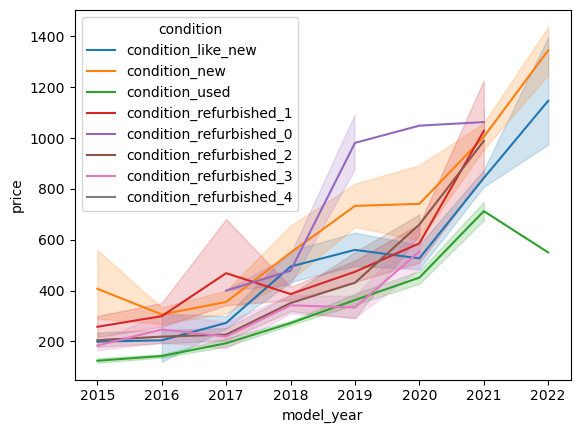

In [72]:
sns.lineplot(data=tp_data_filt, x='model_year', y='price', hue='condition')

<AxesSubplot:xlabel='model_year', ylabel='cost_per_year'>

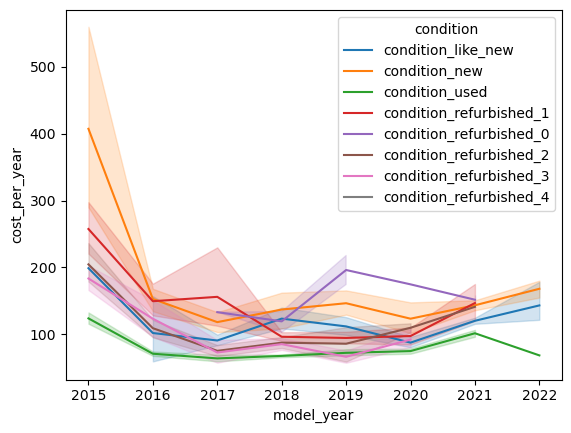

In [73]:
sns.lineplot(data=tp_data_filt, x='model_year', y='cost_per_year', hue='condition')